<a href="https://colab.research.google.com/github/theaveas/DeepLearning/blob/main/NNFS/06_nnfs_introducing_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducing Optimization
The goal of the optimization is to determine how to adjust the weights and biases to decrease the loss.

In [1]:
import platform
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print(platform.python_version())
print(np.__version__)
print(matplotlib. __version__)

#python version 3.9.7
#numpy version 1.21.2
#matplotlib version 3.5.0

3.7.12
1.19.5
3.2.2


In [4]:
# install library
!pip install nnfs

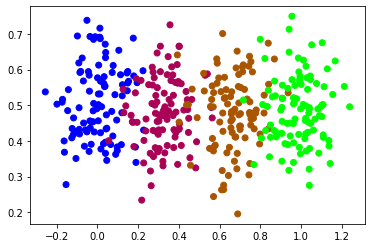

In [5]:
# create dataset
import nnfs
from nnfs.datasets import vertical_data

nnfs.init()

X, y = vertical_data(samples=100, classes=4)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

### NNFS Previous Design Class

In [7]:
# import all the previous define class
import numpy as np

class Dense:
    
    def __init__(self, n_inputs, n_neurons):
        """ Initialize the weights and biases of each neurons
        n_inputs = number of input features
        n_neurons = number of desired neurons
        """
        # using np.random.randn and * 0.01 is to break the symetry of the neurons
        
        self.weights = np.random.randn(n_inputs, n_neurons) * 0.01
        # biases can be initialize as zeros
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        """ Calculate the output layer using The Dot product of input feature and weight plus bias
        Input:
        inputs = Training examples
        
        Output:
        output = Output of the training example
        """
        # calculate the output layer
        self.inputs = inputs
        output = np.dot(inputs, self.weights) + self.biases
        
        return output
    
    def backward(self, dvalues):
        """Calculate gradient descent on parameter

        Args:
            dvalues ([type]): [description]

        Returns:
            [type]: [description]
        """
        self.weights = np.dot(self.inputs.T, dvalues)
        self.biases = np.sum(dvalues, axis=0, keepdims=True)
        self.dinputs = np.dot(dvalues, self.weights.T)
    
# ReLU activation
class Activation_ReLU:
    def forward(self, inputs):
        self.inputs = inputs
        output = np.maximum(0, inputs)
        
        return output
    
    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        
        self.dinputs[self.inputs <=0] = 0
    
# Sotfmax activation
class Activation_Softmax:
    def forward(self, inputs):
        # input - np.max to prevent the exponential function from overflowing
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        
        softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return softmax
   
    
# common loss class
class Loss:

    def calc(self, output, y):
        """ Calculate the data and regularization losses
        Input: 
            output : The output of the activation function
            y : Class targets
            
        Output:
            data_loss : Average Loss
        """
        data_loss = self.forward(output, y)
        
        return data_loss
    

# categorical cross entropy loss 
class Loss_CategoricalCrossentropy(Loss):
    
    def forward(self, y_pred, y):
        """Calculate Cross-entropy loss
        Input : 
            y_pred : The output of the activation function
            y : Class targets
            
        Output :
            average_loss : Average Loss
        """
        # len of training example
        m = len(y_pred)
        
        # clip data to prevent divison by 0
        # clip both sides to not drag mean toward any values
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)
        
        # probabilities for target values only if categorical labels
        if len(y.shape) == 1:
            correct_conf = y_pred_clipped[range(len(y_pred_clipped)), y]
        # one hot encoded
        elif len(y.shape) == 2:
            correct_conf = np.sum(y_pred_clipped * y, axis=1, keepdims=True)

        # compute loss
        average_loss = 1/m * np.sum(-np.log(y_pred_clipped[range(len(y_pred_clipped)), y]))
        
        return average_loss

### Build Neural network

In [8]:
# Create the model
dense1 = Dense(2, 5) # first dense layer, 2 input (x, y coordinate)
activation1 = Activation_ReLU()
dense2 = Dense(5, 4) # second dense layer, 5 inputs, 4 outputs (y is 4 classes)
activation2 = Activation_Softmax()

# compute loss
loss_function = Loss_CategoricalCrossentropy()

In [9]:
#create some variables to track the best loss and the associated wandb
# Helper variables 
lowest_loss = 9999999 # some initial value 
best_dense1_weights = dense1.weights.copy() 
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy() 
best_dense2_biases = dense2.biases.copy()

### Training Neural Network

In [10]:
accuracies = []
losses = []
for i in range(100000):
    
    # initialize random wandb
    dense1.weights = 0.02 * np.random.randn(2, 5)
    dense1.biases = 0.02 * np.random.randn(1, 5)
    dense2.weights = 0.02 * np.random.randn(5, 4)
    dense2.biases = 0.02 * np.random.randn(1, 4)
    
    # forward pass
    z1 = dense1.forward(X)
    a1 = activation1.forward(z1)
    z2 = dense2.forward(a1)
    a2 = activation2.forward(z2)
    
    # compute loss
    loss = loss_function.calc(a2, y)
    losses.append(loss)
    
    # calc the accuracy
    predictions = np.argmax(a2, axis=1)
    acc = np.mean(predictions==y)
    accuracies.append(acc)
    
    # Let's start optimize
    if loss < lowest_loss:
        print('New set of weights found, iteration', i, 
              'loss', loss, 'acc', acc)
        best_dense1_weights = dense1.weights.copy() 
        best_dense1_biases = dense1.biases.copy() 
        best_dense2_weights = dense2.weights.copy() 
        best_dense2_biases = dense2.biases.copy()
        # set the newest loss
        lowest_loss = loss

New set of weights found, iteration 0 loss 1.3863920593261718 acc 0.25
New set of weights found, iteration 5 loss 1.3861563110351562 acc 0.495
New set of weights found, iteration 105 loss 1.3861428833007812 acc 0.25
New set of weights found, iteration 139 loss 1.3861087036132813 acc 0.25
New set of weights found, iteration 160 loss 1.3860665893554687 acc 0.25
New set of weights found, iteration 243 loss 1.3860116577148438 acc 0.25
New set of weights found, iteration 547 loss 1.3858549499511719 acc 0.25
New set of weights found, iteration 6156 loss 1.385614013671875 acc 0.25
New set of weights found, iteration 53444 loss 1.385560302734375 acc 0.25
New set of weights found, iteration 96010 loss 1.3855482482910157 acc 0.25


Loss certainly falls, but not much, acc did not impove

In [11]:
print('Loss of this model: ', losses[:5], '....', losses[-5:])
print('Accuracy of this model: ', accuracies[:5], "...." , accuracies[-5:])

Loss of this model:  [1.3863920593261718, 1.3865589904785156, 1.3865052795410155, 1.3864553833007813, 1.3864898681640625] .... [1.3863153076171875, 1.3861585998535157, 1.3862042236328125, 1.3863092041015626, 1.38630126953125]
Accuracy of this model:  [0.25, 0.25, 0.25, 0.25, 0.25] .... [0.25, 0.25, 0.25, 0.25, 0.25]


In [12]:
# another method is apply a fraction fo these values to parameters, with this, weights will be updateed from what currently yields us the lowest loss instead of aimlessly randomly.
# training neural network

lowest_loss = 9999999 # some initial value 
accuracies = []
losses = []
for i in range(100000):
    
    # initialize random wandb
    dense1.weights += 0.02 * np.random.randn(2, 5)
    dense1.biases += 0.02 * np.random.randn(1, 5)
    dense2.weights += 0.02 * np.random.randn(5, 4)
    dense2.biases += 0.02 * np.random.randn(1, 4)
    
    # forward pass
    z1 = dense1.forward(X)
    a1 = activation1.forward(z1)
    z2 = dense2.forward(a1)
    a2 = activation2.forward(z2)
    
    # compute loss
    loss = loss_function.calc(a2, y)
    losses.append(loss)
    
    # calc the accuracy
    predictions = np.argmax(a2, axis=1)
    acc = np.mean(predictions==y)
    accuracies.append(acc)
    
    # Let's start optimize
    if loss < lowest_loss: 
        if i > i > 99990:
            print('New set of weights found, iteration', i, 
                  'loss', loss, 'acc', acc)  # show only the last 10
        best_dense1_weights = dense1.weights.copy() 
        best_dense1_biases = dense1.biases.copy() 
        best_dense2_weights = dense2.weights.copy() 
        best_dense2_biases = dense2.biases.copy()
        # set the newest loss
        lowest_loss = loss
        
    else:
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()